In [7]:
# import
import pandas as pd
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [8]:
# load data
df = pd.read_csv('C:/Users/C973119/Downloads/VSC/dtc AB testing/cookie cats project/cookie_cats.csv')
print(df.head())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


1. Sanity check

In [9]:
# check user asignment
usercount = df.groupby('version')['userid'].nunique()
print(usercount)

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64


In [10]:
# run chisquare to check assignment randomization
obs = [usercount['gate_30'], usercount['gate_40']]
exp = [usercount.sum()/2, usercount.sum()/2]

chisquare(obs, f_exp=exp)

Power_divergenceResult(statistic=6.9024049496058275, pvalue=0.008607987810836262)

2. EAD

In [11]:
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

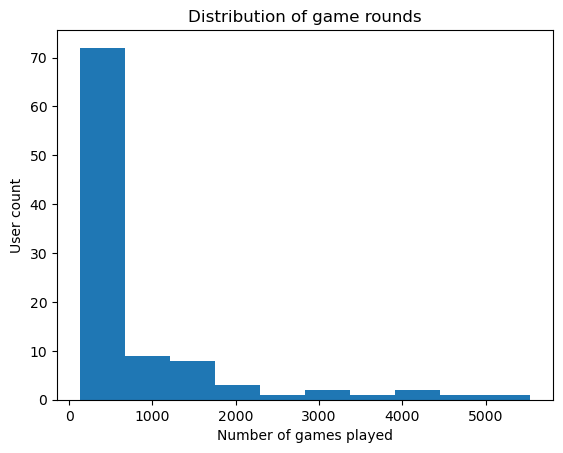

In [12]:
# examine distribution of game rounds
plot_df = df.groupby('sum_gamerounds')['userid'].nunique()

# plot distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot(x='sum_gamerounds', y='userid', kind='hist')
plt.title('Distribution of game rounds')
plt.xlabel('Number of games played')
plt.ylabel('User count')
plt.show()


3. Examine results

In [13]:
# overall 1-day retention 
df.groupby('userid')['retention_1'].max().mean()

0.4452095044850259

In [14]:
# examine 1-day retention by group
ret_1 = df.groupby(['version', 'userid'])['retention_1'].max()
ret_1.groupby('version').mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

4. Result Analysis - Significance test

4.1. Analyze 1-day retention results using Bootstraping method

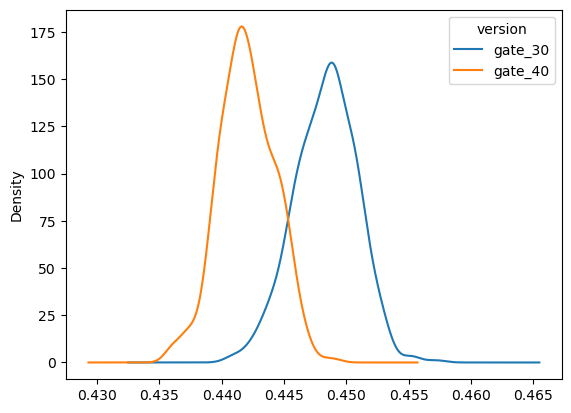

In [15]:
# bootstraping method

boot_1d = []
for i in range(500):
    mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(mean)

boot_1d = pd.DataFrame(boot_1d)

# plot KDE - Kernel density estimate of the bootstrapping distribution
boot_1d.plot(kind='kde')
plt.show()

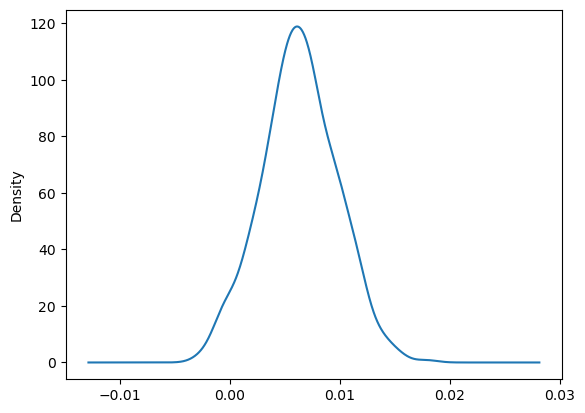

In [16]:
# zooming in the difference
boot_1d['diff'] = boot_1d['gate_30'] - boot_1d['gate_40']

ax = boot_1d['diff'].plot(kind='kde')
plt.show()

In [17]:
# probability of the difference is above 0
prob = (boot_1d['diff'] > 0).sum()/len(boot_1d)

print('probability of difference above 0 is {:.1%}'.format(prob))

probability of difference above 0 is 95.8%


4.2 Analyze 7-day retention results using Proportions_ztest

In [18]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

In [19]:
# run proportion test
reten_7 = df.groupby('version')['retention_7'].sum()
ncount = df.groupby('version')['userid'].count()

proportions_ztest(reten_7, nobs=ncount, alternative='larger')

(3.164358912748191, 0.0007771249878071645)

In [28]:
# examine confidence interval at 95%
(g30_lo95, g40_lo95), (g30_up95, g40_up95) = proportion_confint(reten_7, nobs=ncount, alpha=0.05)

print('At alpha 0.05, retention rate for gate_30 group range from %.4f to %.4f' % (g30_lo95, g30_up95))
print('At alpha 0.05, week retention rate for gate_40 group range from %.4f to %.4f' % (g40_lo95, g40_up95))


At alpha 0.05, retention rate for gate_30 group range from 0.1866 to 0.1938
At alpha 0.05, week retention rate for gate_40 group range from 0.1785 to 0.1855
